# preparations

## install Qiskit

In [1]:
%pip install qiskit qiskit_aer

Note: you may need to restart the kernel to use updated packages.


## loading libraries

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, ReadoutError, thermal_relaxation_error, depolarizing_error
from qiskit.quantum_info import Statevector, Operator

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt as Chebyshev
from timeit import default_timer as timer
from io import StringIO

## noise model with IonQ's Aria specifications
depolarizing error probability is probabilities adjusted from thermal noise infidelity: $p = e^{-t/T_2}$ with gate time for $t$

In [3]:
# error probabilities
p_meas = 3.9e-3
p_reset = 3.9e-3
p_gate1 = 6e-4
p_gate2 = 6e-3

# thermal relaxation error (nanosecond time)
T1s = np.random.choice(range(10, 100), 10, replace=False) # consider adjusting range to be more reasonable
T2 = 1e9

time_meas = np.random.choice(range(600, 700), 10, replace=False)
time_u1 = 0 # virtual gate
time_gate1 = 1.35e5 # u1 and u2
time_gate2 = 6e5 # 2 qubit gate

# thermal relaxation error
ther_u1  = [thermal_relaxation_error(t1 * 1e9, T2, time_u1)
              for t1 in T1s]
ther_gate1  = [thermal_relaxation_error(t1 * 1e9, T2, time_gate1)
              for t1 in T1s]
ther_gate2 = [[thermal_relaxation_error(t1a * 1e9, T2, time_gate2).expand(
             thermal_relaxation_error(t1b * 1e9, T2, time_gate2))
              for t1a in T1s]
               for t1b in T1s]

# depolarizing error
dep_reset = depolarizing_error(p_reset, 1)
dep_gate1 = depolarizing_error(p_gate1 - 1.34990888e-4, 1)
dep_gate2 = depolarizing_error(p_gate2 - 5.99820036e-4, 2)

# readout error
er_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])

# creating the noise model
fake_aria = NoiseModel()

for j in range(10):
    fake_aria.add_quantum_error(ther_u1[j].compose(dep_gate1), "u1", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u2", [j])
    fake_aria.add_quantum_error(ther_gate1[j].compose(dep_gate1), "u3", [j])
    for k in range(10):
        fake_aria.add_quantum_error(ther_gate2[j][k].compose(dep_gate2), "cx", [j, k])
fake_aria.add_all_qubit_quantum_error(dep_reset, "reset")
fake_aria.add_all_qubit_readout_error(er_meas)

## Grover parameter optimizers

In [4]:
# delta, Lambda must be in (0, 1)
def GroverQueryComplexity(delta: float, Lambda: float):
    return int(np.ceil(np.arccosh(1 / delta) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2

# Lambda must be in (0, 1)
def GroverProbability(delta: float, Lambda: float):
    L = 2 * GroverQueryComplexity(delta, Lambda) + 1
    return 1 - np.power(delta * Chebyshev(L, Chebyshev(1 / L, 1 / delta) * np.sqrt(1 - Lambda)), 2)

# Lambda must be in (0, 1), l, N must be positive integers
def GroverParameterOptimizerForComplexity(l: int, Lambda: float, N: int):
    deltas = np.where(np.int8(np.ceil(np.arccosh(1 / np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N)) / np.arccosh(1 / np.sqrt(1 - Lambda)))) // 2 <= l, np.linspace(1 - np.exp2(- N), np.exp2(- N), 1 << N), 0)
    prob = GroverProbability(deltas[0], Lambda)
    for d in deltas[1: np.where(deltas == 0)[0][0]]:
        if GroverProbability(d, Lambda) > prob:
            delta, prob = d, GroverProbability(d, Lambda)

    return delta

# Grover Fixed Point Search for gerenal Quadratic Binary Optimization problems

In [5]:
def GroverFPSForQUBO(QuadraticForm: list[list[int]], digits: int, threshold: int, l: int, delta: float):

    gamma = np.tanh(np.arccosh(1 / delta) / (2 * l + 1))
    GroverPhases = 2 * np.arctan(1 / (gamma * np.tan(np.arange(1, l + 1) * 2 * np.pi / (2 * l + 1))))

    # we often need these values
    PiOverPowerOfTwo = np.pi / (1 << np.arange(max(len(QuadraticForm), digits)))

    # preparation for paralellization (the QuadraticForm is assumed to only have rows/columns with at least one )
    Q = np.triu(QuadraticForm, 1) - np.diag(np.sum(QuadraticForm, axis=0))
    offdiagonals, diagonals, blocks = np.argwhere(np.triu(Q, 1)).tolist(), np.argwhere(np.diag(Q)).tolist(), []
    while offdiagonals != [] or diagonals != []:
        block, qubits, next = [], set(), 0
        while next < len(offdiagonals) and len(block) < digits:
            if qubits.isdisjoint(offdiagonals[next]):
                block.append(offdiagonals.pop(next))
                qubits.update(block[-1])
                if len(block) < digits and block[-1][0] in diagonals:
                    block.append([block[-1][0], block[-1][0]])
                    diagonals.remove(block[-1][1])
            else:
                next += 1
        next = 0
        while next < len(diagonals) and len(block) < digits:
            if diagonals[next][0] not in qubits:
                block.append([diagonals[next][0], diagonals[next][0]])
                qubits.add(diagonals.pop(next)[0])
            else:
                next += 1
        blocks.append(block)

    # circuit preparation
    QRegX = QuantumRegister(len(QuadraticForm), "x") # quantum registers for the bit configurations
    QControl, QTarget = QRegX[:-1], QRegX[-1] # this is just to make the multi-controlled phase gate's code a bit less confusing
    QRegY = AncillaRegister(digits, "y") # quantum registers to digitize values

    QC = QuantumCircuit(QRegX, QRegY, name=f"Grover FPS Circuit")

    # state-preparation
    QC.h(QRegX[:] + QRegY[:])

    # adding threshold - 1
    for i, q in enumerate(reversed(QRegY)):
        QC.rz((threshold - 1) * PiOverPowerOfTwo[i], q)

    # Grover FPS bang-bangs
    for alpha, beta in zip(GroverPhases, reversed(GroverPhases)):

        # S_t (beta)
        for block in blocks:
            for [i, j] in block:
                if i != j:
                    QC.cx(QRegX[i], QRegX[j])

            for d in range(digits):
                for idx, [i, j] in enumerate(block):
                    pos = (d + idx)%digits
                    QC.crz(Q[i, j] * PiOverPowerOfTwo[pos], QRegX[j], QRegY[- 1 - pos])

            for [i, j] in block:
                if i != j:
                    QC.cx(i, j)

        # inverse QFT without the SWAPs
        for i, q in enumerate(reversed(QRegY)):
            QC.h(q)
            for j, r in enumerate(reversed(QRegY[:- i - 1])):
                QC.cp(- PiOverPowerOfTwo[j + 1], q, r)

        QC.rz(beta, QRegY[0])

        # QFT without the SWAPs
        for i, q in enumerate(QRegY):
            QC.h(q)
            for j, r in enumerate(QRegY[i + 1:]):
                QC.cp(PiOverPowerOfTwo[j + 1], q, r)

        for block in blocks:
            for [i, j] in block:
                if i != j:
                    QC.cx(QRegX[i], QRegX[j])

            for d in range(digits):
                for idx, [i, j] in enumerate(block):
                    pos = (d + idx)%digits
                    QC.crz(- Q[i, j] * PiOverPowerOfTwo[pos], QRegX[j], QRegY[- 1 - pos])

            for [i, j] in block:
                if i != j:
                    QC.cx(i, j)

        # S_s (alpha) / this implementation is only better when len(QuadraticForm) > 4
        QC.h(QRegX)
        QC.x(QRegX)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(PiOverPowerOfTwo[j + 1], q, p)
            QC.cp(alpha * np.exp2(- (i + 1)), q, QTarget)

        for i, q in enumerate(QControl[1:]):
            QC.crx(PiOverPowerOfTwo[i], QControl[0], q)
            QC.cp(- alpha * np.exp2(i + 1 - len(QControl)), q, QTarget)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- PiOverPowerOfTwo[j + 1], q, p)

        QC.cp(alpha * np.exp2(1 - len(QControl)), QControl[0], QTarget)

        for i, q in enumerate(reversed(QControl[1:])):
            for j, p in enumerate(QControl[len(QControl) - i:]):
                QC.crx(PiOverPowerOfTwo[j + 1], q, p)

        for i, q in enumerate(QControl[1:]):
            QC.crx(- PiOverPowerOfTwo[i], QControl[0], q)
            for j, p in enumerate(QControl[i + 2:]):
                QC.crx(- PiOverPowerOfTwo[j + 1], q, p)

        QC.x(QRegX)
        QC.h(QRegX)

    return QC

# parameters & testing for MaxCut:

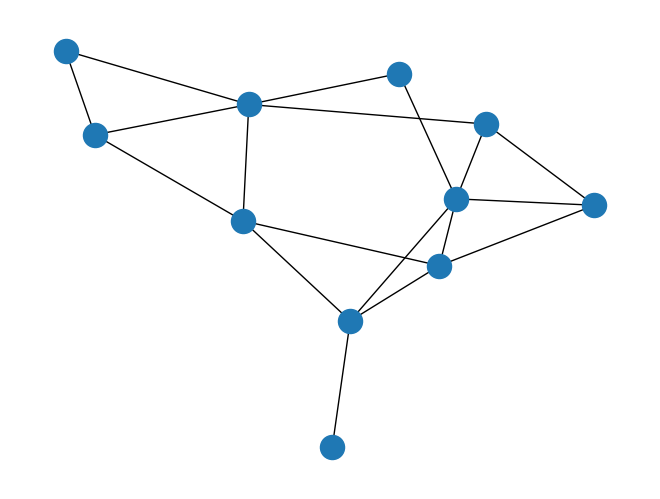

In [6]:
# random, connected graph
NumberOfVertices, EdgeProbability = 11, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)

In [7]:
GraphLaplacian = nx.laplacian_matrix(Graph).toarray()
NumberOfEdges = np.trace(GraphLaplacian) // 2
threshold = int(np.ceil((2 * NumberOfEdges + NumberOfVertices - 1)/4))
digits = 1 + int(np.ceil(np.log2(threshold))) if NumberOfVertices > 2 else 1 # number of ancilla qubits needed to digitize cuts

# let's get rid of the vertex with the highest degree; this step, is not necessary, but saves one qubit
maxdegvertex = np.where(np.diag(GraphLaplacian) == np.max(np.diag(GraphLaplacian)))[0][0]
if maxdegvertex + 1 != NumberOfVertices:
    GraphLaplacian[[maxdegvertex, -1], :] = GraphLaplacian[[-1, maxdegvertex], :]
    GraphLaplacian[:, [maxdegvertex, -1]] = GraphLaplacian[:, [-1, maxdegvertex]]
QuadraticForm = GraphLaplacian[np.ix_(np.arange(NumberOfVertices - 1), np.arange(NumberOfVertices - 1))]

# classical, brute-force cut-function and MaxCut computation
cuts = np.empty(1 << len(QuadraticForm), dtype=int)
for x, _ in enumerate(cuts):
    conf = (x >> np.arange(len(QuadraticForm)))&1
    cuts[x] = np.inner(conf@QuadraticForm, conf)
MaxCut = np.max(cuts)

# cut statistics
RandomChance, Lambda, m, sigma = np.array([np.sum(np.where(cuts == cut, 1, 0)) for cut in range(MaxCut + 1)]) / (1 << (NumberOfVertices - 1)), np.sum(np.where(cuts >= threshold, 1, 0)) * np.exp2(1 - NumberOfVertices), NumberOfEdges / 2, np.std(cuts)

In [8]:
l = 1
delta = GroverParameterOptimizerForComplexity(l, Lambda, 10)
TargetProbability = GroverProbability(delta, Lambda)

print(f"MaxCut\tthreshold\tLambda\ttarget probability\tdelta\tl\tdigits\n{MaxCut}\t{threshold}\t\t{Lambda:.2f}\t{TargetProbability:.2%}\t\t\t{delta:.2}\t{l}\t{digits}\n")

MaxCut	threshold	Lambda	target probability	delta	l	digits
14	12		0.11	68.89%			0.94	1	5



### simulation and evaluation of data:

In [9]:
noise = True
noise = False

print(f"\ncomputation with Grover Fixed-Point Search...\n")
Start = timer()

QC = GroverFPSForQUBO(QuadraticForm, digits, threshold, l, delta)

if noise:
    QC.save_density_matrix(qubits=QC.qubits[:-QC.num_ancillas],
                           label="ϱ")
    simulator = AerSimulator(method="density_matrix",
                             noise_model=fake_aria)
    QC = transpile(circuits=QC,
                   backend=simulator,
                   optimization_level=3)
    psi = simulator.run(QC, shots=1).result().data()["ϱ"]
else:
    QC.save_statevector()
    simulator = AerSimulator(method="statevector")
    QC = transpile(circuits=QC,
                   backend=simulator,
                   basis_gates=["u", "cx", "save_statevector"],
                   optimization_level=3)
    psi = Statevector(simulator.run(QC).result().get_statevector())

print(f"done in {(timer() - Start):.2f} seconds\n")


computation with Grover Fixed-Point Search...

done in 0.39 seconds



In [10]:
probabilities = psi.probabilities(np.arange(QC.num_qubits - QC.num_ancillas))
distribution = np.array([np.sum(np.where(cuts == cut, probabilities, 0)) for cut in range(MaxCut + 1)])
success = np.sum(distribution[threshold:])
M = np.dot(distribution, np.arange(len(distribution)))
var = np.sqrt(np.dot(distribution, np.arange(len(distribution))**2) - M**2)
sign_m, sign_sigma = "+" if M >= m else "-", "+" if var >= sigma else "-"

In [11]:
ss = StringIO(f"simulation with")
ss.write(f"" if noise else f"out")
ss.write(f" noise\n\nthe graph:\n----------\nMaxCut\t\t\t\t= {MaxCut}\nnumber of edges\t\t\t= {NumberOfEdges}\n")
ss.write(f"threshold (Erdős-Edwards bound)\t= {threshold} ({threshold/MaxCut:.1%} of MaxCut)")
ss.write(f"\n\nthe graph Laplacian:\n--------------------\n\n" + f"".join([f"{row.view()}\n" for row in GraphLaplacian]))
ss.write(f"\nGrover parameters:\n------------------\nLambda\t\t\t= {Lambda:.2f}\ndelta\t\t\t= {delta:.2f}")
ss.write(f"\nquery complexity\t= {l}\n\nresults with Grover:\n--------------------\n\n")
ss.write(f"success probability\t= {success:.1%} (theoretical value = {TargetProbability:.1%}, random chance = {Lambda:.1%})\n")
ss.write(f"expectation\t\t= {M:.1f}\t({m} {sign_m} {abs(M - m):.1f})\n")
ss.write(f"variance\t\t= {var:.1f}\t({sigma:.1f} {sign_sigma} {abs(var - sigma):.1f})\n\n")
ss.write(f"CNOT count\t\t= {QC.count_ops()['cx']}\ncircuit depth\t\t= {QC.depth()}")
print(ss.getvalue())

out noise

the graph:
----------
MaxCut				= 14
number of edges			= 18
threshold (Erdős-Edwards bound)	= 12 (85.7% of MaxCut)

the graph Laplacian:
--------------------

[ 1  0  0  0  0  0  0  0  0 -1  0]
[ 0  3 -1  0 -1  0  0  0  0  0 -1]
[ 0 -1  4  0  0 -1  0  0  0 -1 -1]
[ 0  0  0  5  0 -1 -1 -1 -1 -1  0]
[ 0 -1  0  0  2  0  0  0  0  0 -1]
[ 0  0 -1 -1  0  4  0 -1  0 -1  0]
[ 0  0  0 -1  0  0  3 -1  0  0 -1]
[ 0  0  0 -1  0 -1 -1  3  0  0  0]
[ 0  0  0 -1  0  0  0  0  2  0 -1]
[-1  0 -1 -1  0 -1  0  0  0  4  0]
[ 0 -1 -1  0 -1  0 -1  0 -1  0  5]

Grover parameters:
------------------
Lambda			= 0.11
delta			= 0.94
query complexity	= 1

results with Grover:
--------------------

success probability	= 68.9% (theoretical value = 68.9%, random chance = 10.6%)
expectation		= 11.2	(9.0 + 2.2)
variance		= 2.1	(2.1 - 0.1)

CNOT count		= 702
circuit depth		= 618


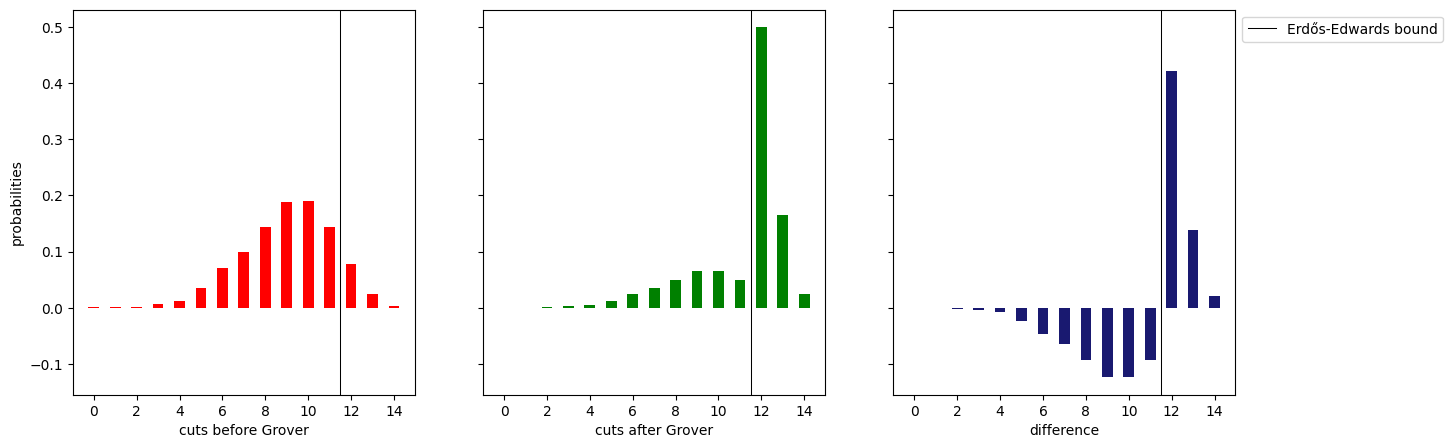

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(np.arange(len(RandomChance)),
           RandomChance,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")
axs[0].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[1].bar(np.arange(len(distribution)),
           distribution,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after Grover")
axs[1].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black")

axs[2].bar(np.arange(len(distribution)),
           distribution - RandomChance,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"difference")
axs[2].axvline(x = threshold - 1/2,
               linewidth=0.75,
               color="black",
               label=f"Erdős-Edwards bound")

plt.legend(bbox_to_anchor = (1.0, 1), loc = "upper left")

plt.show()